<a href="https://colab.research.google.com/github/nikita-resh/StyleGAN-NADA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install Ninja

import torch
import matplotlib.pyplot as plt
import gdown
import clip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zf6ucdf0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zf6ucdf0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=b26fb99c08a0788d8264b195848ff67371af7abb2e669b84485ab9f24aa138ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-28h87it5/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 22.9 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/rosinality/stylegan2-pytorch.git

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395 (from 1)
Receiving objects: 100% (395/395), 122.51 MiB | 14.44 MiB/s, done.
Resolving deltas: 100% (205/205), done.


In [4]:
%cd stylegan2-pytorch

/content/stylegan2-pytorch


In [5]:
from model import Generator

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [6]:
file_path = "/content/stylegan2-pytorch/lpips/__init__.py"

# Откроем файл и прочитаем его содержимое
with open(file_path, 'r') as file:
    lines = file.readlines()

# Заменим нужную строку
with open(file_path, 'w') as file:
    for line in lines:
        # Если в строке есть "compare_ssim", заменим на "structural_similarity"
        if "from skimage.measure import compare_ssim" in line:
            file.write("from skimage.metrics import structural_similarity\n")
        else:
            file.write(line)

print("Замена выполнена успешно!")

Замена выполнена успешно!


In [7]:
# Зададим девайс: cuda или cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# URL for the Google Drive file
url = 'https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT'

# Download the file
gdown.download(url, 'stylegan2-ffhq-config-f.pt', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=8388746e-9d10-46ed-98e8-0c1be2770e8d
To: /content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt
100%|██████████| 381M/381M [00:11<00:00, 32.1MB/s]


'stylegan2-ffhq-config-f.pt'

### CLIP Loss

We want the model to generate images that align with the properties described in the text prompt. To achieve this, we use CLIP loss to encourage the model to generate images that are closer to the text description in the CLIP embedding space.

The CLIP loss is computed as follows:

$$
D_{\text{CLIP}} = 1 - \frac{\langle E_T(G(w)) \cdot E_T(t) \rangle }{\|E_T(G(w))\| \cdot \|E_T(t)\|}
$$

**Where:**

- $E_T$: Text and image encoder function (e.g., CLIP's shared encoder for both text and image).
- $t$: Text description (prompt).
- $G(w)$: Image generated by the generator using the latent vector $w$.
- $D_{\text{CLIP}}$: Cosine distance between the text embedding and the image embedding in the CLIP space.

**Intuition:** The CLIP loss encourages the generated image $G(w)$ to be semantically aligned with the provided text prompt $t$. If the image and text embeddings are close in the CLIP space, the loss will be small, helping the model generate images that reflect the described properties.

In [21]:
class CLIPLoss(torch.nn.Module):
  def __init__(self, stylegan_size=1024):
    super(CLIPLoss, self).__init__()

    self.model, self.preprocess = clip.load("ViT-B/32", device=device)

    # clip only supports images 224*224.
    # we need to resize image with min information loss possible. therefore we firstly apply upsamling, and then pooling.
    # scale_factor=7 allows not to deal with decimals
    self.upsample = torch.nn.Upsample(scale_factor=7)
    self.avg_pool = torch.nn.AvgPool2d(kernel_size=(1024*7//224))

  def forward(self, prompt, image):
    # text preprocessing
    tokenized_prompt = clip.tokenize([prompt]).to(device)
    # image preprocessing
    preprocessed_image = self.avg_pool(self.upsample(image))

    # encoding to CLIP space
    text_features = self.model.encode_text(tokenized_prompt)
    image_features = self.model.encode_image(preprocessed_image)

    # normalize embeddings
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    similarity = (image_features * text_features).sum(dim=1)
    loss = 1 - similarity.mean()

    return loss


### CLIP Directional loss

We want to only change properties described in our text prompt. We use CLIP loss to panish model for changing other properties.

The directional loss is computed as follows:

$$
\Delta T = E_T(t_{\text{target}}) - E_T(t_{\text{source}})
$$

$$
\Delta I = E_I(G_{\text{train}}(w)) - E_I(G_{\text{frozen}}(w))
$$

$$
L_{\text{direction}} = 1 - \frac{\Delta I \cdot \Delta T}{|\Delta I| \cdot |\Delta T|}
$$

**Where:**

- $E_T$: Text encoder function (e.g., CLIP text encoder).
- $E_I$: Image encoder function (e.g., CLIP image encoder).
- $t_{\text{target}}$: Target text description.
- $t_{\text{source}}$: Source text description.
- $G_{\text{train}}$: Trainable generator (e.g., StyleGAN during training).
- $G_{\text{frozen}}$: Frozen generator (pre-trained StyleGAN, unmodified during training).
- $w$: Latent vector input to the generator.

**Intuition:** If the image changes $\Delta I$ don’t align with the text changes $\Delta T$, the loss increases, encouraging the generator to better follow the text guidance during optimization.

In [20]:
class CLIPDirectionalLoss(torch.nn.Module):
  def __init__(self, stylegan_size=1024):
    super(CLIPDirectionalLoss, self).__init__()

    self.model, self.preprocess = clip.load("ViT-B/32", device=device)

    # clip only supports images 224*224.
    # we need to resize image with min information loss possible. therefore we firstly apply upsamling, and then pooling.
    # scale_factor=7 allows not to deal with decimals
    self.upsample = torch.nn.Upsample(scale_factor=7)
    self.avg_pool = torch.nn.AvgPool2d(kernel_size=(1024*7//224))

  def forward(self, frozen_generator_image, trainable_generator_image, source_prompt, target_prompt):
    # text preprocessing
    tokenized_source_prompt = clip.tokenize([source_prompt]).to(device)
    tokenized_target_prompt = clip.tokenize([target_prompt]).to(device)
    # image preprocessing
    preprocessed_frozen_generator_image = self.avg_pool(self.upsample(frozen_generator_image))
    preprocessed_trainable_generator_image = self.avg_pool(self.upsample(trainable_generator_image))

    # encoding to CLIP space
    source_prompt_features = self.model.encode_text(tokenized_source_prompt)
    target_prompt_features = self.model.encode_text(tokenized_target_prompt)
    frozen_generator_image_features = self.model.encode_image(preprocessed_frozen_generator_image)
    trainable_generator_image_features = self.model.encode_image(preprocessed_trainable_generator_image)

    delta_t = target_prompt_features - source_prompt_features
    delta_i = trainable_generator_image_features - frozen_generator_image_features

    # normalize deltas
    delta_i = delta_i / delta_i.norm(dim=1, keepdim=True)
    delta_t = delta_t / delta_t.norm(dim=1, keepdim=True)

    loss = 1 - (delta_i * delta_t).sum(dim=1).mean()

    return loss

In [22]:
clip_loss = CLIPLoss()
clip_directional_loss = CLIPDirectionalLoss()

In [12]:
# Параметры генератора
size = 1024  # Размер изображения
latent_dim = 512  # Размер латентного пространства
n_mlp = 8  # Количество слоев MLP
channel_multiplier = 2
ckpt = '/content/stylegan2-pytorch/stylegan2-ffhq-config-f.pt'  # Путь к весам StyleGAN2

In [13]:
frozen_generator = Generator(size, latent_dim, n_mlp, channel_multiplier=channel_multiplier).to(device)
trainable_generator = Generator(size, latent_dim, n_mlp, channel_multiplier=channel_multiplier).to(device)

frozen_generator.eval()
trainable_generator.train()

checkpoint = torch.load(ckpt)

frozen_generator.load_state_dict(checkpoint["g_ema"])
trainable_generator.load_state_dict(checkpoint["g_ema"])

<ipython-input-13-c7a9903732ad>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt)


<All keys matched successfully>

Step [0/201], Loss: 2.03759765625


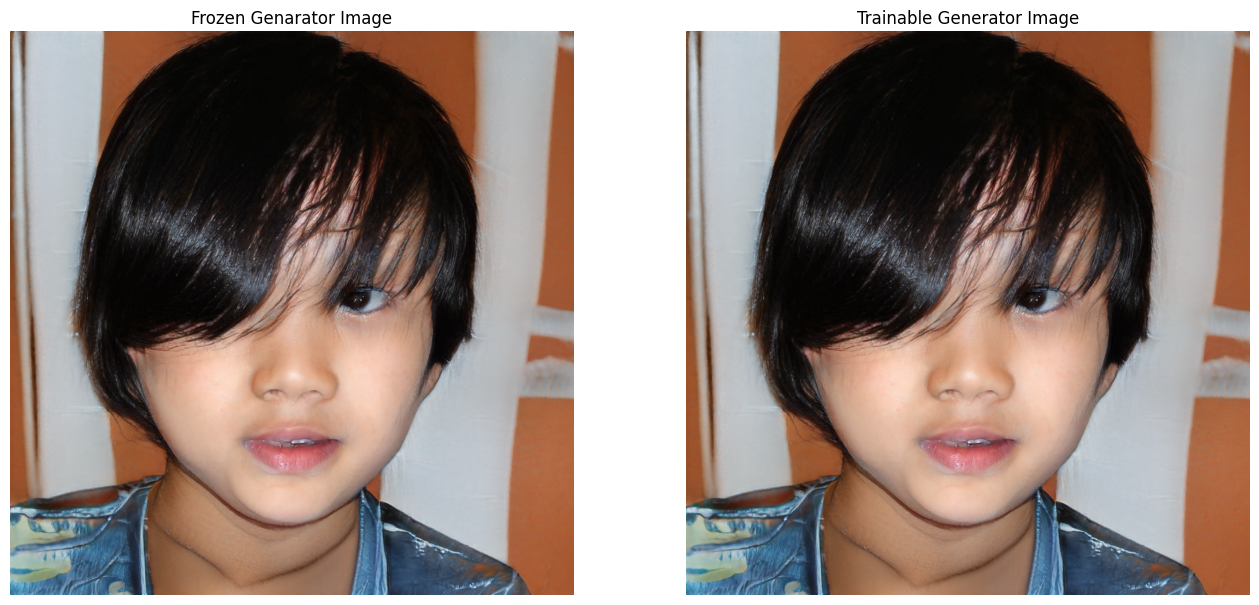

Step [5/201], Loss: 2.103515625


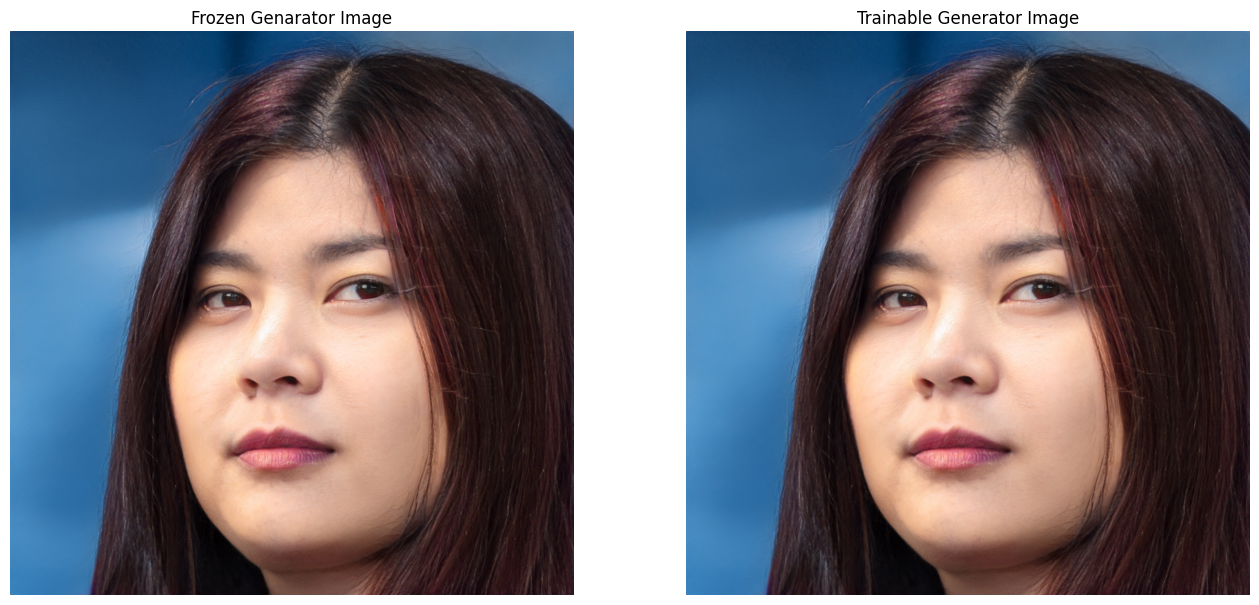

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 5747 has 14.74 GiB memory in use. Of the allocated memory 14.38 GiB is allocated by PyTorch, and 246.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [24]:
num_steps = 201

l2_lambda = 0.01
clip_lambda = 1.5
clip_directional_lambda = 1
id_lambda = 0.0005

optimizer = torch.optim.Adam(trainable_generator.parameters(), lr=0.08)

source_prompt = "photo"
target_prompt = "sketch"

losses = {'l2': [], 'clip': [], 'clip_directional': [], 'total': []}

for step in range(num_steps):
  latent_z = torch.randn((1, latent_dim), device=device)
  latent_w = frozen_generator.style(latent_z).detach().clone()

  frozen_generator_image, _ = frozen_generator([latent_w], input_is_latent=True, randomize_noise=False)
  trainable_generator_image, _ = trainable_generator([latent_w], input_is_latent=True, randomize_noise=False)

  l2_loss_value = torch.sum((frozen_generator_image - trainable_generator_image) ** 2)
  clip_loss_value = clip_loss(target_prompt, trainable_generator_image)
  clip_directional_loss_value = clip_directional_loss(frozen_generator_image, trainable_generator_image, source_prompt, target_prompt)
  loss = l2_lambda * l2_loss_value + clip_lambda * clip_loss_value + clip_directional_lambda * clip_directional_loss_value

  losses['l2'].append(l2_loss_value.detach().item())
  losses['clip'].append(clip_loss_value.detach().item())
  losses['clip_directional'].append(clip_directional_loss_value.detach().item())
  losses['total'].append(loss.detach().item())

  if step % 5 == 0 or step == num_steps -1:
    print(f"Step [{step}/{num_steps}], Loss: {losses['total'][-1]}")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))

    axs[0].imshow((frozen_generator_image.cpu().detach()[0].clip(-1, 1).permute(1, 2, 0) + 1) / 2)
    axs[0].set_title("Frozen Genarator Image")
    axs[0].axis('off')

    axs[1].imshow((trainable_generator_image.cpu().detach()[0].clip(-1, 1).permute(1, 2, 0) + 1) / 2)
    axs[1].set_title("Trainable Generator Image")
    axs[1].axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Steps corresponding to the losses
steps = range(len(losses['id']))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Losses Over Steps', fontsize=16)

# Titles and keys for the losses
titles = [ 'L2 Loss', 'CLIP Loss', 'CLIP Directional' 'Total Loss']
loss_keys = ['l2', 'clip', 'clip_directional', 'total']

# Plot each loss
for i, ax in enumerate(axs.flat):
    loss_key = loss_keys[i]
    ax.plot(steps, losses[loss_key], marker='o', label=f'{loss_key.upper()} Loss')
    ax.set_title(titles[i])
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()

# Adjust layout to fit the title and spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()